In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import time
#import math
#importing packages
import seaborn as sns
import matplotlib.pyplot as plt


# Sklearn
import sklearn
# Preprocessor from sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras
import keras
# ANNs from keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Dense, LSTM

# Import cufflinks for visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =(20,10)
plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Feature selection
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# Feature importance
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
#from skpp import ProjectionPursuitRegressor
#from skpp import ProjectionPursuitClassifier
# # ANNs
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

# Model Metrics
from sklearn.metrics import accuracy_score
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Resample
# Block Bootstrap
#from arch.bootstrap import StationaryBootstrap
# Time Series cross-validation
#from sklearn.model_selection import TimeSeriesSplit

# Class encoder
#from sklearn.preprocessing import LabelEncoder 

seed_value = 4

## Loading data 

In [2]:
df = pd.read_csv('DATA_FRAME_CURATED.csv')

In [3]:
df = df.dropna()

In [4]:
df.index = df["Date"]

In [5]:
df.drop(["Date"],1,inplace=True)

In [6]:
df.shape

(2980, 18)

In [7]:
list(df.keys())

['Y_next_returns',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'daily_returns',
 'day-of-week',
 'week-of-year',
 'month-of-year',
 'gold_returns',
 'oil_returns',
 'yield_returns',
 'nasdaq_returns',
 'dowJones_returns',
 'VIX_returns',
 'RSI',
 'MACD_Signal']

In [8]:
X=df.copy()

In [9]:
# 70% train/test split
split = int(len(X) * 0.7)

In [10]:
X_train = X[:split]

## The goal is to find the down_threshold and the up_threshold that splits the data set in 3 balanced categories

In [11]:
n = len(X_train["Y_next_returns"]<0.03)

In [12]:
m=int(n/3)

In [13]:
down_threshold = min(X_train["Y_next_returns"])
up_threshold = max(X_train["Y_next_returns"])

In [14]:
down_threshold = -0.15736796427678823

In [15]:
up_threshold = 0.28718284189909205

In [16]:
#while ((X_train["Y_next_returns"]<=down_threshold).sum())<m:
#    down_threshold=down_threshold+0.0001    
#while ((X_train["Y_next_returns"]>=up_threshold).sum())<m:
#    up_threshold=up_threshold-0.0001

In [17]:
print("Threshold to consider a DOWN prediction: ", down_threshold)

Threshold to consider a DOWN prediction:  -0.15736796427678823


In [18]:
print("Threshold to consider an UP prediction: ", up_threshold)

Threshold to consider an UP prediction:  0.28718284189909205


In [19]:
n_up=(X_train["Y_next_returns"]>=up_threshold).sum()
n_up

695

In [20]:
n_down=(X_train["Y_next_returns"]<=down_threshold).sum()
n_down

695

In [21]:
n_lateral = len(X_train["Y_next_returns"])-(X_train["Y_next_returns"]<=down_threshold).sum()-(X_train["Y_next_returns"]>=up_threshold).sum()
n_lateral

696

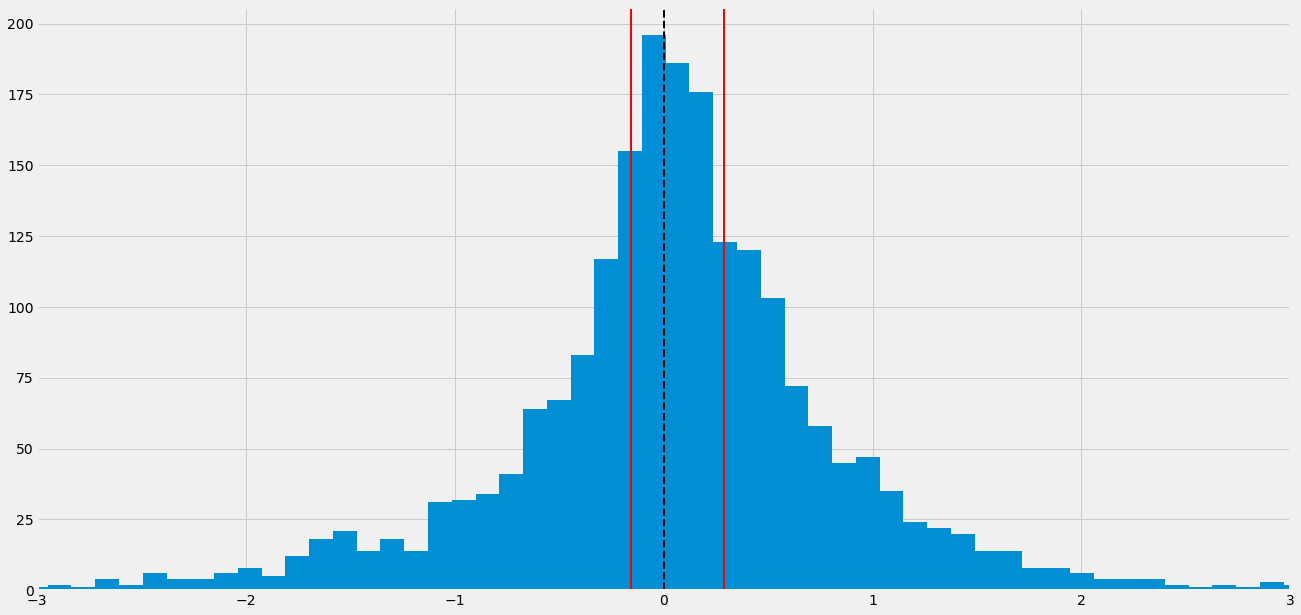

In [22]:
plt.hist(X_train["Y_next_returns"], bins=100)
plt.axvline(down_threshold, color='r', linestyle='solid', linewidth=2)
plt.axvline(up_threshold, color='r', linestyle='solid', linewidth=2)
plt.axvline(0, color='k', linestyle='--', linewidth=2)
plt.xlim([-3, 3])
plt.show()

## Labeling classes

In [23]:
label=[]
for i in range(len(X["Y_next_returns"])):

    if X["Y_next_returns"][i]<=down_threshold:
        
        label.append(0)
        
    elif X["Y_next_returns"][i]>down_threshold and X["Y_next_returns"][i]<up_threshold:
    
        label.append(1)
        
    elif X["Y_next_returns"][i]>=up_threshold:
        label.append(2)


In [24]:
#Testing that all the returns are classified correctly
my_list = list(set(label))
my_list

[0, 1, 2]

In [25]:
Y_next_returns = X["Y_next_returns"]

In [26]:
X.drop("Y_next_returns",1,inplace=True)

In [27]:
Y=label

## Classifing and Splitting the Data Set

In [28]:
#for k in data_threshold.keys():

#Y=data_threshold[k]

# 70% train/test split
split = int(len(X) * 0.7)

# We transform Y to a binary classification problem's values (0 y 1)
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder() 
encoder.fit(Y) 
encoded_Y = encoder.transform(Y) 
# We transform encoded_Y into a dataframe in order to use .iloc and being able to make the train/test split
Y = pd.DataFrame(encoded_Y, columns = ['Column_A'],index=X.index) 

# Create train data set
# We have to twist the dataset
X_train, y_train = X[:split], Y[:split]
# Test data after train split
# PARA EVITAR CORRELACION ENTRE LAS SERIES PODEMOS TOMAR [SPLIT+3:] ie QUE PREDIGA 3 DIAS ADELANTE DEL TRAIN SET
X_test, y_test = X[split:], Y[split:]


# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)


# We change from array to dataframe
X_train=pd.DataFrame(scaled_X_train,columns=X.columns,index=X.iloc[:split].index)
y_train=pd.DataFrame(y_train,columns=Y.columns,index=Y[:split].index)
X_test=pd.DataFrame(scaled_X_test,columns=X.columns,index=X[split:].index)
y_test=pd.DataFrame(y_test,columns=Y.columns,index=Y[split:].index)


In [29]:

clf = DecisionTreeClassifier()

start_clf = time.time()
clf.fit(X_train, y_train)
end_clf = time.time()
clf_runtime=end_clf - start_clf

print('Runtime:',clf_runtime)
print("score on test: %.3f"  % clf.score(X_test, y_test))
print("score on train: %.3f" % clf.score(X_train, y_train))

Runtime: 0.035901784896850586
score on test: 0.342
score on train: 1.000


In [30]:
y_test_predicted=clf.predict(X_test)

In [31]:
y_test_predicted

array([0, 1, 0, 0, 1, 1, 0, 0, 2, 2, 1, 2, 2, 0, 1, 1, 0, 0, 2, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 0,
       1, 2, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [32]:
y_test = y_test.rename(columns = {"Column_A":"Real"})

In [33]:
y_test["Predicted"] = y_test_predicted

In [34]:
y_test.head(5)

,Real,Predicted
Date,,
2018-06-11,1,0
2018-06-12,0,1
2018-06-13,1,0
2018-06-14,1,0
2018-06-15,2,1


In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
cm = confusion_matrix(y_test["Real"],y_test["Predicted"])

In [37]:
cm_df = pd.DataFrame(cm,
                     index = ['DOWN','LATERAL','UP'], 
                     columns = ['DOWN','LATERAL','UP'])

In [38]:
cm

array([[181,  43,  77],
       [173,  49,  53],
       [194,  48,  76]], dtype=int64)

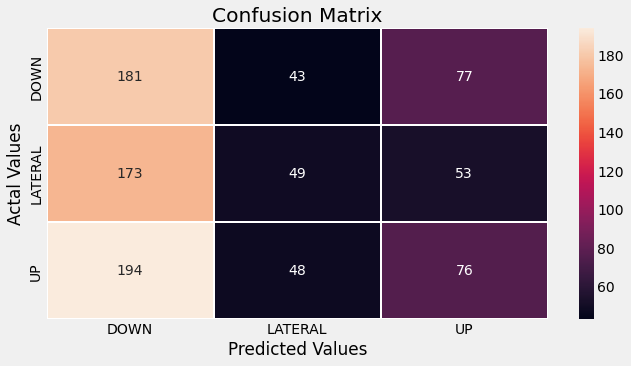

In [39]:
#Plotting the confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, linewidths=1, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [40]:
cm_df

,DOWN,LATERAL,UP
DOWN,181,43,77
LATERAL,173,49,53
UP,194,48,76


In [41]:
print("y_test en Real casos Downs: ",(y_test["Real"]==0).sum())
print("y_test en Real casos Lateral: ",(y_test["Real"]==1).sum())
print("y_test en Real casos UP: ",(y_test["Real"]==2).sum())

y_test en Real casos Downs:  301
y_test en Real casos Lateral:  275
y_test en Real casos UP:  318


In [42]:
print("Casos Downs, Accuracy considering all cases Down: ",(y_test["Real"]==0).sum()/len(y_test["Real"]))
print("Casos Lateral, Accuracy considering all cases Lateral: ",(y_test["Real"]==1).sum()/len(y_test["Real"]))
print("Casos UP, Accuracy considering all cases UP: ",(y_test["Real"]==2).sum()/len(y_test["Real"]))

Casos Downs, Accuracy considering all cases Down:  0.3366890380313199
Casos Lateral, Accuracy considering all cases Lateral:  0.3076062639821029
Casos UP, Accuracy considering all cases UP:  0.35570469798657717


In [43]:
print("y_test en Predicted casos Downs: ",(y_test["Predicted"]==0).sum())
print("y_test en Predicted casos Lateral: ",(y_test["Predicted"]==1).sum())
print("y_test en Predicted casos UP: ",(y_test["Predicted"]==2).sum())

y_test en Predicted casos Downs:  548
y_test en Predicted casos Lateral:  140
y_test en Predicted casos UP:  206


In [44]:
print("Casos Downs, Accuracy considering all cases Down: ",(y_test["Predicted"]==0).sum()/len(y_test["Predicted"]))
print("Casos Lateral, Accuracy considering all cases Lateral: ",(y_test["Predicted"]==1).sum()/len(y_test["Predicted"]))
print("Casos UP, Accuracy considering all cases UP: ",(y_test["Predicted"]==2).sum()/len(y_test["Predicted"]))

Casos Downs, Accuracy considering all cases Down:  0.6129753914988815
Casos Lateral, Accuracy considering all cases Lateral:  0.15659955257270694
Casos UP, Accuracy considering all cases UP:  0.23042505592841164


## Adding the returns

In [45]:
y_test["returns"]=df["Y_next_returns"][split:]

In [46]:
y_test.shape

(894, 3)

## Values were actions are taken

In [47]:
y_test = y_test[y_test["Predicted"]!=1]

In [48]:
y_test.shape

(754, 3)

In [49]:
y_test.head(10)

,Real,Predicted,returns
Date,,,
2018-06-11,1,0,0.044864
2018-06-13,1,0,-0.025872
2018-06-14,1,0,0.067653
2018-06-19,1,0,-0.087047
2018-06-20,0,0,-0.707373
2018-06-21,0,2,-0.214304
2018-06-22,0,2,-0.947620
2018-06-26,0,2,-1.061898
2018-06-27,2,2,0.650791


## popi


In [50]:
y_test["action"]=y_test["Real"]==y_test["Predicted"]

In [51]:
y_test.head(10)

,Real,Predicted,returns,action
Date,,,,
2018-06-11,1,0,0.044864,False
2018-06-13,1,0,-0.025872,False
2018-06-14,1,0,0.067653,False
2018-06-19,1,0,-0.087047,False
2018-06-20,0,0,-0.707373,True
2018-06-21,0,2,-0.214304,False
2018-06-22,0,2,-0.947620,False
2018-06-26,0,2,-1.061898,False
2018-06-27,2,2,0.650791,True


In [52]:
y_test["position"] = np.where(y_test["Predicted"]<1, -1, 1 )

In [53]:
y_test

,Real,Predicted,returns,action,position
Date,,,,,
2018-06-11,1,0,0.044864,False,-1
2018-06-13,1,0,-0.025872,False,-1
2018-06-14,1,0,0.067653,False,-1
2018-06-19,1,0,-0.087047,False,-1
2018-06-20,0,0,-0.707373,True,-1
...,...,...,...,...,...
2021-12-23,2,2,1.201035,True,1
2021-12-27,0,0,-0.190780,True,-1
2021-12-28,1,2,0.092258,False,1


In [54]:
y_test["strategy"] = y_test.position * y_test["returns"]

In [55]:
y_test

,Real,Predicted,returns,action,position,strategy
Date,,,,,,
2018-06-11,1,0,0.044864,False,-1,-0.044864
2018-06-13,1,0,-0.025872,False,-1,0.025872
2018-06-14,1,0,0.067653,False,-1,-0.067653
2018-06-19,1,0,-0.087047,False,-1,0.087047
2018-06-20,0,0,-0.707373,True,-1,0.707373
...,...,...,...,...,...,...
2021-12-23,2,2,1.201035,True,1,1.201035
2021-12-27,0,0,-0.190780,True,-1,0.190780
2021-12-28,1,2,0.092258,False,1,0.092258


In [56]:
y_test["strategy_returns"] = (100+y_test["strategy"])/100

In [57]:
y_test.head(10)

,Real,Predicted,returns,action,position,strategy,strategy_returns
Date,,,,,,,
2018-06-11,1,0,0.044864,False,-1,-0.044864,0.999551
2018-06-13,1,0,-0.025872,False,-1,0.025872,1.000259
2018-06-14,1,0,0.067653,False,-1,-0.067653,0.999323
2018-06-19,1,0,-0.087047,False,-1,0.087047,1.000870
2018-06-20,0,0,-0.707373,True,-1,0.707373,1.007074
2018-06-21,0,2,-0.214304,False,1,-0.214304,0.997857
2018-06-22,0,2,-0.947620,False,1,-0.947620,0.990524
2018-06-26,0,2,-1.061898,False,1,-1.061898,0.989381
2018-06-27,2,2,0.650791,True,1,0.650791,1.006508


In [58]:
returns=[]
returns.append(1)
j=0
for i in y_test["strategy_returns"]:
    returns.append(returns[j]*i)
    j=j+1

In [59]:
returns

[1,
 0.99955136430936,
 0.9998099652791927,
 0.9991335654760467,
 1.000003279207773,
 1.007077032903405,
 1.004918823662283,
 0.9953960144054281,
 0.984825922723259,
 0.9912350859412248,
 0.9944241391123612,
 0.9899006502153388,
 0.9819273335351576,
 0.9849473373402695,
 0.9830841415064406,
 0.9851374732572856,
 0.9868502331247521,
 0.976974299824454,
 0.9763026707795628,
 0.9844185062203182,
 0.9901622136654757,
 0.9878531123611086,
 0.9905915677122924,
 0.9811779143833069,
 0.9774643031907688,
 0.9739912477385146,
 0.9731287811472922,
 0.972818880641405,
 0.974048747581328,
 0.9759788810256215,
 0.9806471284966365,
 0.9764669426799675,
 0.979780392879316,
 0.9829760096425241,
 0.9788944826662221,
 0.9778248708607374,
 0.977329524267963,
 0.9770460062562191,
 0.9781773433733382,
 0.9823852882749963,
 0.9782901740995893,
 0.97961613857842,
 0.9750943281764681,
 0.9777158279707453,
 0.9787778169423434,
 0.9788589043067112,
 0.9798715972222753,
 0.9834704377632204,
 0.9822985117515033,
 

In [60]:
y_test["strategy_returns_accum"]=returns[1:len(returns)+1]

In [61]:
y_test

,Real,Predicted,returns,action,position,strategy,strategy_returns,strategy_returns_accum
Date,,,,,,,,
2018-06-11,1,0,0.044864,False,-1,-0.044864,0.999551,0.999551
2018-06-13,1,0,-0.025872,False,-1,0.025872,1.000259,0.999810
2018-06-14,1,0,0.067653,False,-1,-0.067653,0.999323,0.999134
2018-06-19,1,0,-0.087047,False,-1,0.087047,1.000870,1.000003
2018-06-20,0,0,-0.707373,True,-1,0.707373,1.007074,1.007077
...,...,...,...,...,...,...,...,...
2021-12-23,2,2,1.201035,True,1,1.201035,1.012010,1.025196
2021-12-27,0,0,-0.190780,True,-1,0.190780,1.001908,1.027152
2021-12-28,1,2,0.092258,False,1,0.092258,1.000923,1.028100


In [62]:
X["Close"]

Date
2010-02-22    1108.010010
2010-02-23    1094.599976
2010-02-24    1105.239990
2010-02-25    1102.939941
2010-02-26    1104.489990
                 ...     
2021-12-23    4725.790039
2021-12-27    4791.189941
2021-12-28    4786.350098
2021-12-29    4793.060059
2021-12-30    4778.729980
Name: Close, Length: 2980, dtype: float64

In [63]:
df_1=df["Close"][split:]

In [64]:
df_1=pd.DataFrame(df_1)

In [65]:
df_1

,Close
Date,
2018-06-11,2782.000000
2018-06-12,2786.850098
2018-06-13,2775.629883
2018-06-14,2782.489990
2018-06-15,2779.659912
...,...
2021-12-23,4725.790039
2021-12-27,4791.189941
2021-12-28,4786.350098


In [66]:
df_1["returns_hold"] = np.log(df_1.Close.div(df_1.Close.shift(1)))

In [67]:
df_1

,Close,returns_hold
Date,,
2018-06-11,2782.000000,NaN
2018-06-12,2786.850098,0.001742
2018-06-13,2775.629883,-0.004034
2018-06-14,2782.489990,0.002469
2018-06-15,2779.659912,-0.001018
...,...,...
2021-12-23,4725.790039,0.006204
2021-12-27,4791.189941,0.013744
2021-12-28,4786.350098,-0.001011


In [68]:
df_1["creturns_hold"] = df_1["returns_hold"].cumsum().apply(np.exp)

In [69]:
df_1

,Close,returns_hold,creturns_hold
Date,,,
2018-06-11,2782.000000,NaN,NaN
2018-06-12,2786.850098,0.001742,1.001743
2018-06-13,2775.629883,-0.004034,0.997710
2018-06-14,2782.489990,0.002469,1.000176
2018-06-15,2779.659912,-0.001018,0.999159
...,...,...,...
2021-12-23,4725.790039,0.006204,1.698702
2021-12-27,4791.189941,0.013744,1.722211
2021-12-28,4786.350098,-0.001011,1.720471


In [70]:
y_test

,Real,Predicted,returns,action,position,strategy,strategy_returns,strategy_returns_accum
Date,,,,,,,,
2018-06-11,1,0,0.044864,False,-1,-0.044864,0.999551,0.999551
2018-06-13,1,0,-0.025872,False,-1,0.025872,1.000259,0.999810
2018-06-14,1,0,0.067653,False,-1,-0.067653,0.999323,0.999134
2018-06-19,1,0,-0.087047,False,-1,0.087047,1.000870,1.000003
2018-06-20,0,0,-0.707373,True,-1,0.707373,1.007074,1.007077
...,...,...,...,...,...,...,...,...
2021-12-23,2,2,1.201035,True,1,1.201035,1.012010,1.025196
2021-12-27,0,0,-0.190780,True,-1,0.190780,1.001908,1.027152
2021-12-28,1,2,0.092258,False,1,0.092258,1.000923,1.028100


In [71]:
df_1["returns_strategy"]=y_test["strategy_returns_accum"]

In [72]:
df_1.returns_strategy.fillna(method = "ffill", inplace= True)

In [73]:
df_1

,Close,returns_hold,creturns_hold,returns_strategy
Date,,,,
2018-06-11,2782.000000,NaN,NaN,0.999551
2018-06-12,2786.850098,0.001742,1.001743,0.999551
2018-06-13,2775.629883,-0.004034,0.997710,0.999810
2018-06-14,2782.489990,0.002469,1.000176,0.999134
2018-06-15,2779.659912,-0.001018,0.999159,0.999134
...,...,...,...,...
2021-12-23,4725.790039,0.006204,1.698702,1.025196
2021-12-27,4791.189941,0.013744,1.722211,1.027152
2021-12-28,4786.350098,-0.001011,1.720471,1.028100


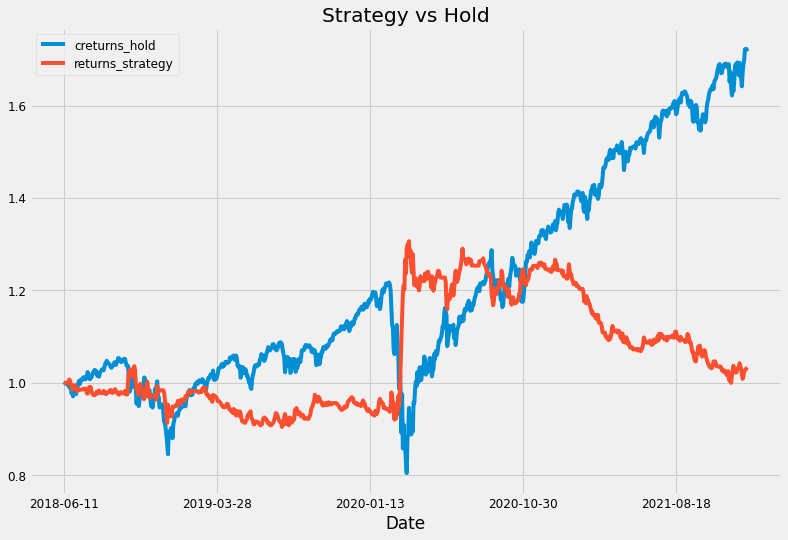

In [74]:
df_1[["creturns_hold","returns_strategy"]].plot(figsize = (12, 8), title = "Strategy vs Hold", fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

In [75]:
df_1["cummax_hold"] = df_1.creturns_hold.cummax()
df_1["cummax_strategy"] = df_1.returns_strategy.cummax()

In [76]:
df_1["drawndown_hold"] =     df_1["cummax_hold"] - df_1["creturns_hold"]
df_1["drawndown_strategy"] = df_1["cummax_strategy"] - df_1["returns_strategy"]

In [77]:
df_1

,Close,returns_hold,creturns_hold,returns_strategy,cummax_hold,cummax_strategy,drawndown_hold,drawndown_strategy
Date,,,,,,,,
2018-06-11,2782.000000,NaN,NaN,0.999551,NaN,0.999551,NaN,0.000000
2018-06-12,2786.850098,0.001742,1.001743,0.999551,1.001743,0.999551,0.000000,0.000000
2018-06-13,2775.629883,-0.004034,0.997710,0.999810,1.001743,0.999810,0.004033,0.000000
2018-06-14,2782.489990,0.002469,1.000176,0.999134,1.001743,0.999810,0.001567,0.000676
2018-06-15,2779.659912,-0.001018,0.999159,0.999134,1.001743,0.999810,0.002585,0.000676
...,...,...,...,...,...,...,...,...
2021-12-23,4725.790039,0.006204,1.698702,1.025196,1.698702,1.306550,0.000000,0.281353
2021-12-27,4791.189941,0.013744,1.722211,1.027152,1.722211,1.306550,0.000000,0.279397
2021-12-28,4786.350098,-0.001011,1.720471,1.028100,1.722211,1.306550,0.001740,0.278450


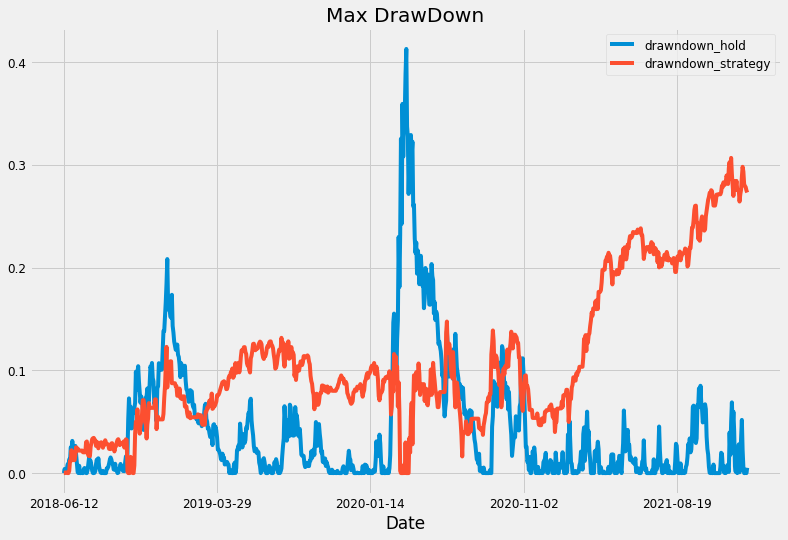

In [78]:
df_1[["drawndown_hold", "drawndown_strategy"]].dropna().plot(figsize = (12, 8), title = "Max DrawDown", fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

In [79]:
Y.shape

(2980, 1)

In [80]:
X.shape

(2980, 17)

In [81]:
Y

,Column_A
Date,
2010-02-22,0
2010-02-23,2
2010-02-24,1
2010-02-25,1
2010-02-26,2
...,...
2021-12-23,2
2021-12-27,0
2021-12-28,1
